# Plotting Datasets
First we import the usual packages

The magic command ``%pylab`` imports matplotlib and numpy

Additionally we need the package ``sidpy``


In [4]:
%pylab --no-import-all notebook 

import sys
sys.path.append('../../')
import sidpy as sid

print(sid.__version__)

Populating the interactive namespace from numpy and matplotlib
0.0.2


## Plotting an Image

We make a sidpy dataset from a numpy array

For plotting it is important to set the dimensions correctly.

In [5]:
# First we make a stack of images
x = np.random.normal(3, 2.5, size=(512, 512))

dset = sid.Dataset.from_array(x)
dset.data_type = 'image'
dset.units = 'counts'
dset.quantity = 'intensity'


dset.set_dimension(0, sid.Dimension('x',np.arange(dset.shape[0])*.02))
dset.x.dimension_type = 'spatial'
dset.x.units = 'nm'
dset.x.quantity = 'distance'
dset.set_dimension(1, sid.Dimension('y',np.arange(dset.shape[1])*.02))
dset.y.dimension_type = 'spatial'
dset.yunits = 'nm'
dset.y.quantity = 'distance'

Now we plot.

<IPython.core.display.Javascript object>


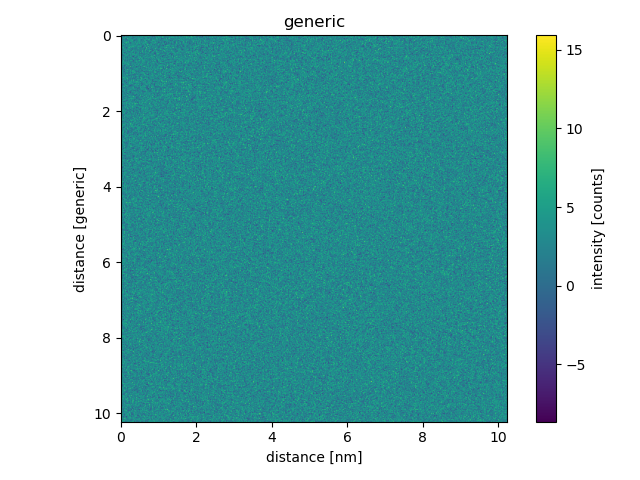

In [6]:
dset.plot()


## Creating a Image-Stack DataSet 
In the following we will make a numpy which resembles a stack of images

In the ``sidpy Dataset`` will set the ``data_type`` to ``image_stack`` for the plotting routine to know how to plot this dataset.

The dimensions have to contain at least two ``spatial`` dimensions and one that is identifiable as a stack dimension ('stack, 'frame', 'time').


In [7]:
# First we make a stack of images
x = np.random.normal(3, 2.5, size=(25, 512, 512))

dset = sid.Dataset.from_array(x)
dset.data_type = 'image_stack'
dset.units = 'counts'
dset.quantity = 'intensity'

dset.set_dimension(0, sid.Dimension('frame', np.arange(dset.shape[0])))
dset.frame.dimension_type = 'time'
dset.set_dimension(1, sid.Dimension('x', np.arange(dset.shape[1])*.02))
dset.x.dimension_type = 'spatial'
dset.x.units = 'nm'
dset.x.quantity = 'distance'
dset.set_dimension(2, sid.Dimension('y', np.arange(dset.shape[2])*.02))
dset.y.dimension_type = 'spatial'
dset.yunits = 'nm'
dset.y.quantity = 'distance'

## Plotting the Dataset

Please note that the scroll wheel will move you through the stack.

Zoom to an area and let it play!

Click on the ``Average`` button and then click on it again.

<IPython.core.display.Javascript object>


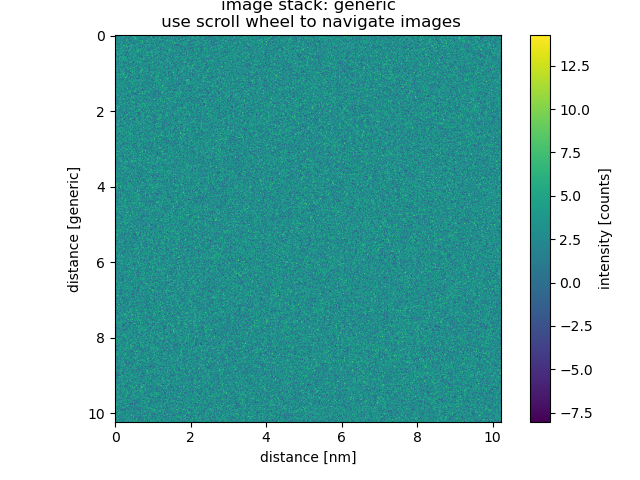

In [8]:
dset.plot()

The kwargs dictionary is used to plot the image stack in TEM style with scale bar

Shape of dataset is:  (25, 512, 512)
3D dataset


<IPython.core.display.Javascript object>


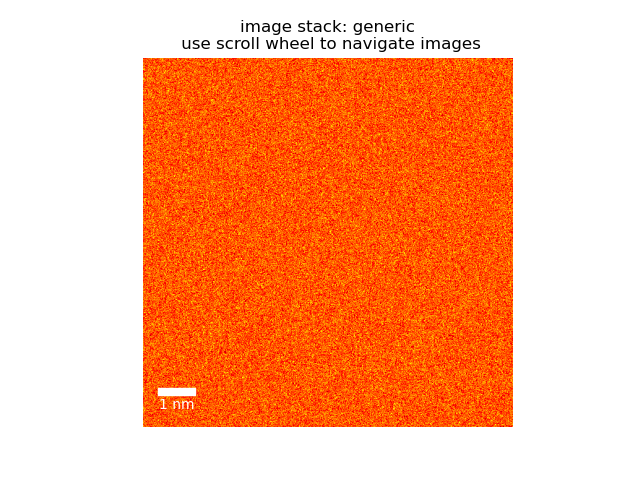

In [9]:
kwargs = {'scale_bar': True, 'cmap': 'hot'}  # or maby 'cmap': 'gray'
 
dset.plot(verbose=True, **kwargs)

## Plot Dataset as Spectral Image
We need to change the data_type of the dataset to ``spectrum_image`` and the dimension_type of one dimension to ``spectral``.

Now the plot function plots it as a spectrum image.

Select the spectrum with the mouse (left click).

<IPython.core.display.Javascript object>


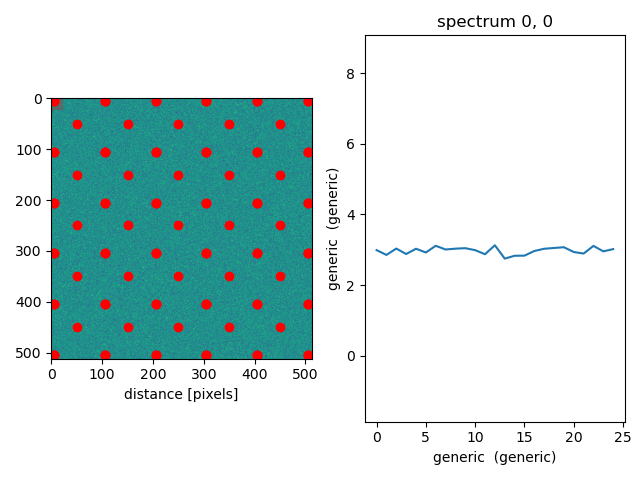

In [29]:
dset.data_type = 'spectrum_image'
dset.set_dimension(0, sid.Dimension('spectrum',np.arange(dset.shape[0])))
dset.spectrum.dimension_type = 'spectral'

dset.plot()

We make the selection more visible by setting the binning of the spectra selection.

The binning avrages over the binning box.

Run the code-cell below and look in the plot above.

In [30]:
dset.view.set_bin([20,20])

The axes (and figure) instances of matplotlib can be accessed throught the ``view`` attribute of  the sidpy dataset. 

In [34]:
x,y = np.mgrid[0:501:100,0:501:100]+5
dset.view.axes[0].scatter(x,y, color = 'red');

## Appendix
The visualization classes in sidpy.viz.dataset_viz

In [18]:
class ImageStackVisualizer(object):
    """
    Interactive display of image stack plot

    The stack can be scrolled through with a mouse wheel or the slider
    The ususal zoom effects of matplotlib apply.
    Works on every backend because it only depends on matplotlib.

    Important: keep a reference to this class to maintain interactive properties so usage is:

    >>view = ImageStackVisualizer(dataset)

    Input:
    ------
    - dset: NSI_dataset
    - - figure: optional
            matplotlib figure
    - kwargs: optional
            matplotlib additional arguments like {cmap: 'hot'}

    """

    def __init__(self, dset, figure=None, **kwargs):
        #from sid.dataset import Dataset

        if not isinstance(dset, sid.Dataset):
            raise TypeError('dset should be a sidpy.Dataset object')
        fig_args = dict()
        temp = kwargs.pop('figsize', None)
        if temp is not None:
            fig_args['figsize'] = temp

        if figure is None:
            self.fig = plt.figure(**fig_args)
        else:
            self.fig = figure

        if dset.ndim < 3:
            raise KeyError('dataset must have at least three dimensions')

        self.stack_dim = -1
        self.image_dims = []
        self.selection = []
        for dim, axis in dset.axes.items():
            if axis.dimension_type == 'spatial':
                self.selection.append(slice(None))
                self.image_dims.append(dim)
            elif axis.dimension_type in ['frame', 'time', 'stack'] or len(dset) == 3:
                self.selection.append(slice(0, 1))
                self.stack_dim = dim
            else:
                self.selection.append(slice(0, 1))

        if len(self.image_dims) != 2:
            raise ValueError('We need two dimensions with dimension_type spatial to plot an image')

        if self.stack_dim < 0:
            raise KeyError('We need one dimensions with dimension_type stack, time or frame')

        if len(self.image_dims) < 2:
            raise KeyError('spatial key in dimension_dictionary must be list of length 2')

        self.dset = dset

        # self.axis = self.fig.add_axes([0.0, 0.2, .9, .7])
        self.ind = 0

        self.number_of_slices = self.dset.shape[self.stack_dim]
        self.axis = None
        self.plot_image(**kwargs)
        self.axis.set_title('image stack: ' + dset.title + '\n use scroll wheel to navigate images')
        self.img.axes.figure.canvas.mpl_connect('scroll_event', self._onscroll)

        import ipywidgets as iwgt
        self.play = iwgt.Play(
            value=0,
            min=0,
            max=self.number_of_slices,
            step=1,
            interval=500,
            description="Press play",
            disabled=False
        )
        self.slider = iwgt.IntSlider(
            value=0,
            min=0,
            max=self.number_of_slices,
            continuous_update=False,
            description="Frame:")
        # set the slider function
        iwgt.interactive(self._update, frame=self.slider)
        # link slider and play function
        iwgt.jslink((self.play, 'value'), (self.slider, 'value'))

        # We add a button to average the images
        button = iwgt.widgets.ToggleButton(
            value=False,
            description='Average',
            disabled=False,
            button_style='',  # 'success', 'info', 'warning', 'danger' or ''
            tooltip='Average Images of Stack')

        button.observe(self._average_slices, 'value')

        # set play and slider widgets next to each other
        widg = iwgt.HBox([self.play, self.slider, button])
        display(widg)

        # self.anim = animation.FuncAnimation(self.fig, self._updatefig, interval=200, blit=False, repeat=True)
        self._update()

    def plot_image(self, **kwargs):

        from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
        from IPython.display import display
        scale_bar = kwargs.pop('scale_bar', False)
        self.axis = plt.gca()
        self.axis.set_title(self.dset.title)

        self.img = self.axis.imshow(np.squeeze(self.dset[tuple(self.selection)]).T,
                                    extent=self.dset.get_extent(self.image_dims), **kwargs)
        self.axis.set_xlabel("{} [{}]".format(self.dset.axes[self.image_dims[0]].quantity,
                                              self.dset.axes[self.image_dims[0]].units))
        self.axis.set_ylabel("{} [{}]".format(self.dset.axes[self.image_dims[1]].quantity,
                                              self.dset.axes[self.image_dims[1]].units))
    
        if scale_bar:

            plt.axis('off')
            extent = self.dset.get_extent(self.image_dims)
            size_of_bar = int((extent[1]-extent[0])/10+.5)
            if size_of_bar < 1:
                size_of_bar = 1
            scalebar = AnchoredSizeBar(plt.gca().transData,
                                       size_of_bar, '{} {}'.format(size_of_bar,
                                                                   self.dset.axes[self.image_dims[0]].units),
                                       'lower left',
                                       pad=1,
                                       color='white',
                                       frameon=False,
                                       size_vertical=.2)

            plt.gca().add_artist(scalebar)

        else:
            cbar = self.fig.colorbar(self.img)
            cbar.set_label("{} [{}]".format(self.dset.quantity, self.dset.units))

            self.axis.ticklabel_format(style='sci', scilimits=(-2, 3))
            self.fig.tight_layout()
        self.img.axes.figure.canvas.draw_idle()

    def _average_slices(self, event):
        if event.new:
            if len(self.dset.shape) == 3:
                image_stack = self.dset
            else:
                stack_selection = self.selection.copy()
                stack_selection[self.stack_dim] = slice(None)
                image_stack = np.squeeze(self.dset[stack_selection])
            
            self.img.set_data(np.average(image_stack, axis=self.stack_dim))
            self.fig.canvas.draw_idle()
        elif event.old:
            self._update(self.ind)

    def _onscroll(self, event):
        print("%s %s" % (event.button, event.step))
        if event.button == 'up':
            self.slider.value = (self.slider.value + 1) % self.number_of_slices
        else:
            self.slider.value = (self.slider.value - 1) % self.number_of_slices
        self.ind = int(self.slider.value)
        

    def _update(self, frame=0):
        self.ind = frame
        self.selection[self.stack_dim] = slice(frame, frame+1)
        self.img.set_data(self.dset[tuple(self.selection)].T)
        self.img.axes.figure.canvas.draw_idle()



<IPython.core.display.Javascript object>


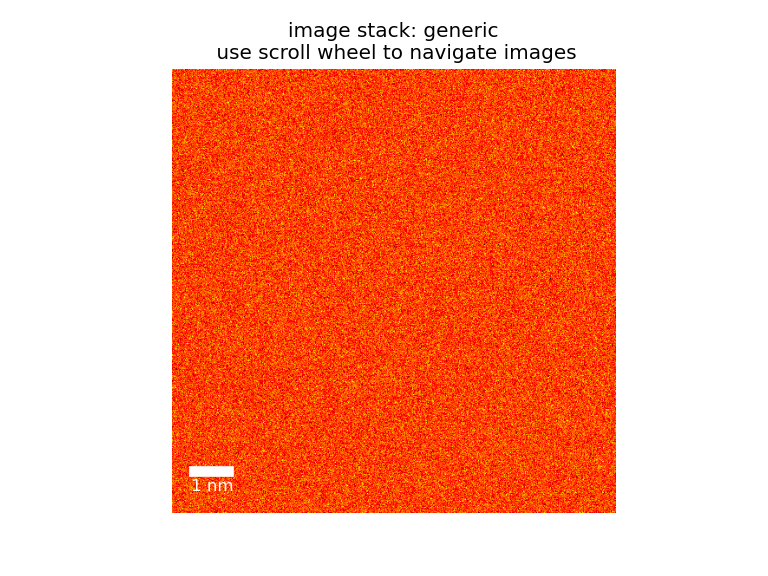

In [19]:
kwargs = {'scale_bar': True, 'cmap': 'hot'}
    
view = ImageStackVisualizer(dset, **kwargs )

In [14]:
class ImageVisualizer(object):
    """
    Interactive display of image plot

    The stack can be scrolled through with a mouse wheel or the slider
    The ususal zoom effects of matplotlib apply.
    Works on every backend because it only depends on matplotlib.

    Important: keep a reference to this class to maintain interactive properties so usage is:

    >>view = plot_stack(dataset, {'spatial':[0,1], 'stack':[2]})

    Input:
    ------
    - dset: NSIDask _dataset
    - dim_dict: dictionary
        with key: "spatial" list of int: dimension of image
    """

    def __init__(self, dset, figure=None, image_number=0, **kwargs):
        #from sidpy.dataset import Dataset

        """
        plotting of data according to two axis marked as 'spatial' in the dimensions
        """
        if not isinstance(dset, sid.Dataset):
            raise TypeError('dset should be a sidpy.Dataset object')
        fig_args = dict()
        temp = kwargs.pop('figsize', None)
        if temp is not None:
            fig_args['figsize'] = temp

        if figure is None:
            self.fig = plt.figure(**fig_args)
        else:
            self.fig = figure

        self.dset = dset
        self.image_number = image_number

        self.selection = []
        self.image_dims = []
        
        
        for dim, axis in dset.axes.items():
            if axis.dimension_type == 'spatial':
                self.selection.append(slice(None))
                self.image_dims.append(dim)
            else:
                if image_number <= dset.shape[dim]:
                    self.selection.append(slice(image_number, image_number+1))
                else:
                    self.image_number = 0
                    self.selection.append(slice(0, 1))
        if len(self.image_dims) != 2:
            raise ValueError('We need two dimensions with dimension_type spatial to plot an image')

        if False:  # is_complex_dtype(self.dset):
            # Plot real and image
            fig, axes = plt.subplots(nrows=2, **fig_args)
            for axis, ufunc, comp_name in zip(axes.flat, [np.abs, np.angle], ['Magnitude', 'Phase']):
                cbar_label = self.data_descriptor
                if comp_name == 'Phase':
                    cbar_label = 'Phase (rad)'
                plot_map(axis, ufunc(np.squeeze(img)), show_xy_ticks=True, show_cbar=True,
                         cbar_label=cbar_label, x_vec=ref_dims[1].values, y_vec=ref_dims[0].values,
                         **kwargs)
                axis.set_title(self.name + '\n(' + comp_name + ')', pad=15)
                axis.set_xlabel(ref_dims[1].name + ' (' + ref_dims[1].units + ')' + suffix[1])
                axis.set_ylabel(ref_dims[0].name + ' (' + ref_dims[0].units + ')' + suffix[0])
            fig.tight_layout()

        else:
            self.axis = self.fig.add_subplot(1, 1, 1)
            self.plot_image(**kwargs)

    def plot_image(self, **kwargs):
        from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
        scale_bar = kwargs.pop('scale_bar', False)
        if len(dset.shape) > 2:
            self.axis.set_title(self.dset.title+'_image {}'.format(self.image_number ))
        else:
            self.axis.set_title(self.dset.title)
        

        self.img = self.axis.imshow(self.dset[tuple(self.selection)].T,
                                    extent=self.dset.get_extent(self.image_dims), **kwargs)
        self.axis.set_xlabel("{} [{}]".format(self.dset.axes[self.image_dims[0]].quantity,
                                              self.dset.axes[self.image_dims[0]].units))
        self.axis.set_ylabel("{} [{}]".format(self.dset.axes[self.image_dims[1]].quantity,
                                              self.dset.axes[self.image_dims[1]].units))
        if scale_bar:

            plt.axis('off')
            extent = self.dset.get_extent(self.image_dims)
            size_of_bar = int((extent[1]-extent[0])/10+.5)
            if size_of_bar < 1:
                size_of_bar = 1
            scalebar = AnchoredSizeBar(plt.gca().transData,
                                       size_of_bar, '{} {}'.format(size_of_bar,
                                                                   self.dset.axes[self.image_dims[0]].units),
                                       'lower left',
                                       pad=1,
                                       color='white',
                                       frameon=False,
                                       size_vertical=.2)

            plt.gca().add_artist(scalebar)

        else:
            cbar = self.fig.colorbar(self.img)
            cbar.set_label("{} [{}]".format(self.dset.quantity, self.dset.units))

            self.axis.ticklabel_format(style='sci', scilimits=(-2, 3))
            self.fig.tight_layout()
        self.img.axes.figure.canvas.draw_idle()


(25, 512, 512)


<IPython.core.display.Javascript object>


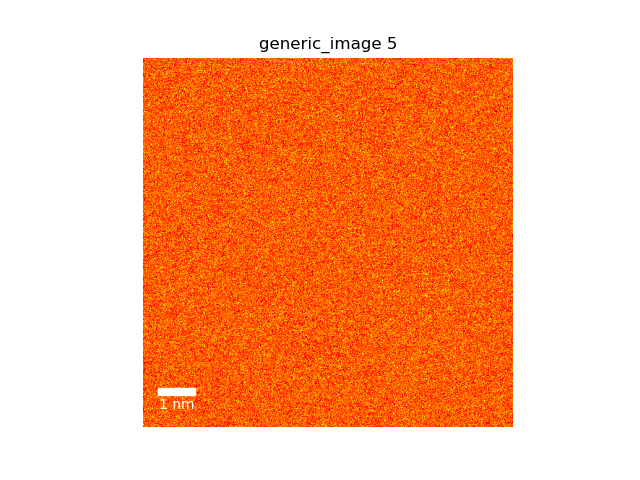

In [15]:
print(dset.shape)
kwargs = {'scale_bar': True, 'cmap': 'hot'}
view = ImageVisualizer(dset, image_number = 5, **kwargs)

In [16]:
import matplotlib.patches as patches
class SpectralImageVisualizer(object):
    """
    ### Interactive spectrum imaging plot

    """

    def __init__(self, dset, figure=None, horizontal=True, **kwargs):
        #from ..sid.dataset import Dataset

        if not isinstance(dset, sid.Dataset):
            raise TypeError('dset should be a sidpy.Dataset object')

        fig_args = dict()
        temp = kwargs.pop('figsize', None)
        if temp is not None:
            fig_args['figsize'] = temp

        if figure is None:
            self.fig = plt.figure(**fig_args)
        else:
            self.fig = figure

        if len(dset.shape) < 3:
            raise KeyError('dataset must have at least three dimensions')

        # We need one stack dim and two image dimes as lists in dictionary

        selection = []
        image_dims = []
        spectral_dims = []
        for dim, axis in dset.axes.items():
            if axis.dimension_type == 'spatial':
                selection.append(slice(None))
                image_dims.append(dim)
            elif axis.dimension_type == 'spectral':
                selection.append(slice(0, 1))
                spectral_dims.append(dim)
            else:
                selection.append(slice(0, 1))
        if len(image_dims) != 2:
            raise ValueError('We need two dimensions with dimension_type spatial to plot an image')

        if len(image_dims) != 2:
            raise KeyError('spatial key in dimension_dictionary must be list of length 2')

        if len(spectral_dims) != 1:
            raise KeyError('spectral key in dimension_dictionary must be list of length 1')

        # extent = dset.get_extent([image_dims[0], image_dims[1]])

        self.horizontal = horizontal
        self.x = 0
        self.y = 0
        self.bin_x = 1
        self.bin_y = 1

        size_x = dset.shape[image_dims[0]]
        size_y = dset.shape[image_dims[1]]

        self.dset = dset
        self.energy_scale = dset.axes[spectral_dims[0]].values

        self.extent = [0, size_x, size_y, 0]
        self.rectangle = [0, size_x, 0, size_y]
        self.scaleX = 1.0
        self.scaleY = 1.0
        self.analysis = []
        self.plot_legend = False

        self.image_dims = image_dims
        print(image_dims)
        self.spec_dim = spectral_dims[0]

        if horizontal:
            self.axes = self.fig.subplots(ncols=2)
        else:
            self.axes = self.fig.subplots(nrows=2, **fig_args)

        self.fig.canvas.set_window_title(self.dset.title)
        self.image = np.average(self.dset, axis=spectral_dims[0])

        self.axes[0].imshow(self.image.T, extent=self.extent, **kwargs)
        if horizontal:
            self.axes[0].set_xlabel('{} [pixels]'.format(self.dset.axes[image_dims[0]].quantity))
        else:
            self.axes[0].set_ylabel('{} [pixels]'.format(self.dset.axes[image_dims[1]].quantity))
        self.axes[0].set_aspect('equal')

        # self.rect = patches.Rectangle((0,0),1,1,linewidth=1,edgecolor='r',facecolor='red', alpha = 0.2)
        self.rect = patches.Rectangle((0, 0), self.bin_x, self.bin_y, linewidth=1, edgecolor='r',
                                      facecolor='red', alpha=0.2)

        self.axes[0].add_patch(self.rect)
        self.intensity_scale = 1.
        self.spectrum = self.get_spectrum()

        self.axes[1].plot(self.energy_scale, self.spectrum)
        self.axes[1].set_title('spectrum {}, {}'.format(self.x, self.y))
        self.xlabel = "{}  ({})".format(self.dset.axes[self.spec_dim].quantity, self.dset.axes[self.spec_dim].units)
        self.axes[1].set_xlabel(self.xlabel)  # + x_suffix)
        self.ylabel = "{}  ({})".format(self.dset.axes[self.spec_dim].quantity, self.dset.axes[self.spec_dim].units)
        self.axes[1].set_ylabel(self.ylabel)
        self.axes[1].ticklabel_format(style='sci', scilimits=(-2, 3))
        self.fig.tight_layout()
        self.cid = self.axes[1].figure.canvas.mpl_connect('button_press_event', self._onclick)

        self.fig.canvas.draw_idle()

    def set_bin(self, bin_xy):

        old_bin_x = self.bin_x
        old_bin_y = self.bin_y
        if isinstance(bin_xy, list):

            self.bin_x = int(bin_xy[0])
            self.bin_y = int(bin_xy[1])

        else:
            self.bin_x = int(bin_xy)
            self.bin_y = int(bin_xy)

        if self.bin_x > self.dset.shape[self.image_dims[0]]:
            self.bin_x = self.dset.shape[self.image_dims[0]]
        if self.bin_y > self.dset.shape[self.image_dims[1]]:
            self.bin_y = self.dset.shape[self.image_dims[1]]

        self.rect.set_width(self.rect.get_width() * self.bin_x / old_bin_x)
        self.rect.set_height((self.rect.get_height() * self.bin_y / old_bin_y))
        if self.x + self.bin_x > self.dset.shape[self.image_dims[0]]:
            self.x = self.dset.shape[0] - self.bin_x
        if self.y + self.bin_y > self.dset.shape[self.image_dims[1]]:
            self.y = self.dset.shape[1] - self.bin_y

        self.rect.set_xy([self.x * self.rect.get_width() / self.bin_x + self.rectangle[0],
                          self.y * self.rect.get_height() / self.bin_y + self.rectangle[2]])
        self._update()

    def get_spectrum(self):

        if self.x > self.dset.shape[self.image_dims[0]] - self.bin_x:
            self.x = self.dset.shape[self.image_dims[0]] - self.bin_x
        if self.y > self.dset.shape[self.image_dims[1]] - self.bin_y:
            self.y = self.dset.shape[self.image_dims[1]] - self.bin_y
        selection = []

        for dim, axis in self.dset.axes.items():
            print(dim, axis.dimension_type )
            if axis.dimension_type == 'spatial':
                if dim == self.image_dims[0]:
                    selection.append(slice(self.x, self.x + self.bin_x))
                else:
                    selection.append(slice(self.y, self.y + self.bin_y))

            elif axis.dimension_type == 'spectral':
                selection.append(slice(None))
            else:
                selection.append(slice(0, 1))
                
        self.spectrum = np.squeeze(np.average(self.dset[tuple(selection)], axis=self.image_dims))
        # * self.intensity_scale[self.x,self.y]
        return np.squeeze(self.spectrum)

    def _onclick(self, event):
        self.event = event
        if event.inaxes in [self.axes[0]]:
            x = int(event.xdata)
            y = int(event.ydata)

            x = int(x - self.rectangle[0])
            y = int(y - self.rectangle[2])

            if x >= 0 and y >= 0:
                if x <= self.rectangle[1] and y <= self.rectangle[3]:
                    self.x = int(x / (self.rect.get_width() / self.bin_x))
                    self.y = int(y / (self.rect.get_height() / self.bin_y))

                    if self.x + self.bin_x > self.dset.shape[self.image_dims[0]]:
                        self.x = self.dset.shape[self.image_dims[0]] - self.bin_x
                    if self.y + self.bin_y > self.dset.shape[self.image_dims[1]]:
                        self.y = self.dset.shape[self.image_dims[1]] - self.bin_y

                    self.rect.set_xy([self.x * self.rect.get_width() / self.bin_x + self.rectangle[0],
                                      self.y * self.rect.get_height() / self.bin_y + self.rectangle[2]])
        self._update()

    def _update(self, ev=None):

        xlim = self.axes[1].get_xlim()
        ylim = self.axes[1].get_ylim()
        self.axes[1].clear()
        self.get_spectrum()

        self.axes[1].plot(self.energy_scale, self.spectrum, label='experiment')

        self.axes[1].set_title('spectrum {}, {}'.format(self.x, self.y))

        self.axes[1].set_xlim(xlim)
        self.axes[1].set_ylim(ylim)
        self.axes[1].set_xlabel(self.xlabel)
        self.axes[1].set_ylabel(self.ylabel)

        self.fig.canvas.draw_idle()

    def set_legend(self, set_legend):
        self.plot_legend = set_legend

    def get_xy(self):
        return [self.x, self.y]

<IPython.core.display.Javascript object>


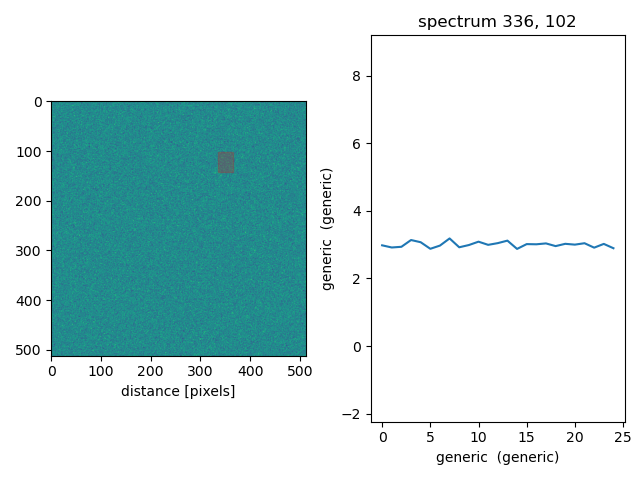

[1, 2]
0 spectral
1 spatial
2 spatial


In [18]:
dset.data_type = 'spectrum_image'
dset.set_dimension(0, sid.Dimension('spectrum',np.arange(dset.shape[0])))
dset.spectrum.dimension_type = 'spectral'
view = SpectralImageVisualizer(dset)
#dset.plot()

In [19]:
view.set_bin([30,40])

0 spectral
1 spatial
2 spatial


# Plot

In [ ]:
dset.data_type = 'spectrum_image'
dset.set_dimension(0, sid.Dimension('spectrum',np.arange(dset.shape[0])))
dset.spectrum.dimension_type = 'spectral'
#view = SpectralImageVisualizer(dset)
dset.plot()

In [95]:
selection = [slice(None), slice(0,1), slice(0,1)]

print(np.average(dset[tuple(selection)], axis=[1,2]).shape)

(25,)
